In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import time
import copy

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

In [3]:
BATCH_SIZE = 256
W = H = 224

train_path = './data/train/'
test_path = './data/test/'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

we have 31072 different samples
And there are 582 different combinations of labels in our dataset


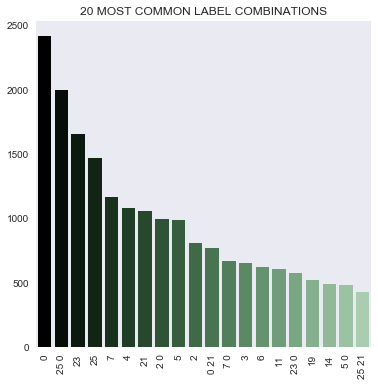

In [4]:
LABELS = []

for label in LABEL_MAP.values():
    LABELS.append(label)
    
train_csv_path = './data//train.csv'

df = pd.read_csv(train_csv_path)

TRAINING_SAMPLES = df.shape[0]

print("we have " + str(TRAINING_SAMPLES) + " different samples")
print("And there are "+  str(len(df.Target.unique())) + " different combinations of labels in our dataset")

import seaborn as sns
sns.set(style="dark")

n = 20

values = df['Target'].value_counts()[:n].keys().tolist()
counts = df['Target'].value_counts()[:n].tolist()

plt.figure(figsize=(6,6))
pal = sns.cubehelix_palette(n, start=2, rot=0, dark=0, light=.75, reverse=True)
g = sns.barplot(y=counts, x=values, palette=pal)
g.set_title(str(n)+" MOST COMMON LABEL COMBINATIONS")
g.set_xticklabels(g.get_xticklabels(),rotation=90);

Load images for a given id:

In [5]:
from PIL import Image

def load_image(basepath, image_id): # Take 3 channels for now
    images = np.zeros(shape=(W,H,3))
    r = Image.open(basepath+image_id+"_red.png").resize((W,H))
    g = Image.open(basepath+image_id+"_green.png").resize((W,H))
    b = Image.open(basepath+image_id+"_blue.png").resize((W,H))
#     y = Image.open(basepath+image_id+"_yellow.png").resize((224,224))

    images[:,:,0] = np.asarray(r)
    images[:,:,1] = np.asarray(g)
    images[:,:,2] = np.asarray(b)
#     images[:,:,3] = np.asarray(y)
    
    return images

In [6]:
# key & values from unique target combinations
targets = df['Target'].value_counts().keys()
counts = df['Target'].value_counts().values

In [7]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import warnings
warnings.filterwarnings("ignore")
from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer
classes = np.arange(0,28)
mlb = MultiLabelBinarizer(classes)
mlb.fit(classes)

class HumanProteinDataset(Dataset):

    def __init__(self, csv_file,transform=None, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            test (Boolean): the csv no contains labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.test = test
        self.complete_df = pd.read_csv(csv_file)
        
        if not test:
            self.path = train_path
            self.loadData()
        else:
            self.path = test_path
            self.df = self.complete_df
            
        self.transform = transform
        
    def CreateDummyVariables(self):
        self.complete_df['Targets'] = self.complete_df['Target'].map(lambda x: list(map(int, x.strip().split())))
            
    def loadData(self):
        self.CreateDummyVariables()
        self.df = pd.DataFrame(columns=['Id','Target'])
        for i, target in enumerate(targets):
            fdf = self.complete_df[self.complete_df['Target'] == target]
            sample = fdf.sample(frac=1, replace=False)
            self.df = self.df.append(sample)
        self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __getitem__(self, idx):
        
        image = load_image(self.path, self.df['Id'].iloc[idx])
        
        sample = {'image': image}

        if not self.test:
            target = np.array(self.complete_df['Targets'].iloc[idx])
            target = mlb.transform([target])
            sample['target'] = target
        
        else:
            sample['Id'] = self.df['Id'].iloc[idx]

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.df.shape[0]
    
    def shape(self):
        return self.df.shape
    
class imgPreprocess(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __init__(self,mean,std, degrees):
        
        self.mean = mean
        self.std = std
        self.degrees = degrees

    def __call__(self, sample):
        
        image = sample['image']/255.0
        image = Image.fromarray(np.uint8(image*255)) # from numpy array to PIL image
        
        totensor = transforms.ToTensor()
        normalize = transforms.Normalize(self.mean,self.std)
        rotate = transforms.RandomRotation(self.degrees)
        hflip = transforms.RandomHorizontalFlip()
        
        if "target" in sample.keys():
            ret = {'image': normalize(totensor(hflip(image)))}
            target = sample['target'][0]
            ret['target'] = target
        else:
            ret = {'image': normalize(totensor(image))}
            ret['Id'] = sample['Id']
                  
        return ret

In [8]:
# mean = np.array([0.08069, 0.05258, 0.05487, 0.08282])
# std = np.array([0.13704, 0.10145, 0.15313, 0.13814])
mean = np.array([0.08069, 0.05258, 0.05487])
std = np.array([0.13704, 0.10145, 0.15313])

dataset = HumanProteinDataset(train_csv_path, transform=imgPreprocess(mean,std,30))

Check if images are being loaded right and visualize some of them:

In [9]:
def Show(sample):
#     f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,15), sharey=True) 
    title = ''
    
    labels =sample['target']
                
    for i, label in enumerate(LABELS):
        if labels[i] == 1:
            if title == '': title += label
            else: title += " & " + label
            
    ax1.imshow(sample['image'][0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(sample['image'][1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(sample['image'][2,:,:],cmap="bone")
    ax3.set_title('Blue')
#     ax4.imshow(sample['image'][3,:,:],cmap="afmhot")
#     ax4.set_title('Yellow')
    f.suptitle(title, fontsize=10, y=0.65)

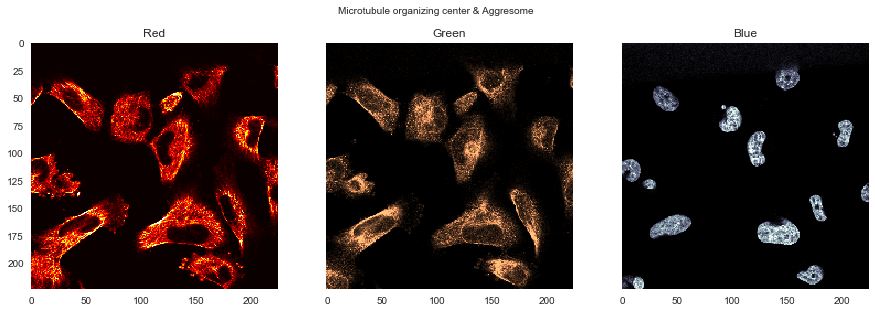

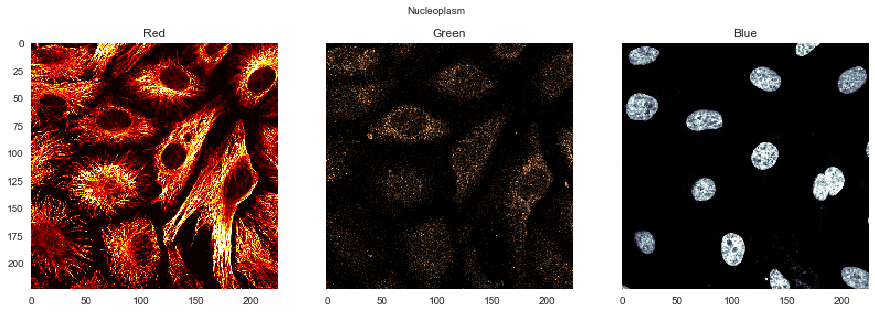

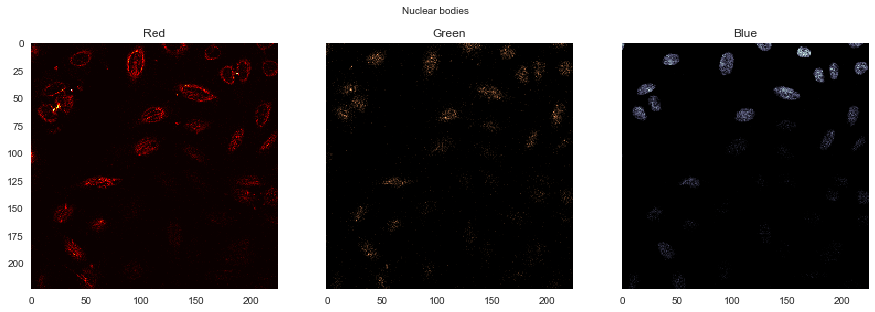

In [10]:
import random

idxs = random.sample(range(1, dataset.df.shape[0]), 3)

for idx in idxs:
    Show(dataset[idx])

# TRAINING

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import math

np.random.seed(42)

def prepare_loaders():
    dataset.loadData()
    num_train = len(dataset)
    indices = list(range(num_train))
    val_size = int(0.2 * num_train) 

    # Random, non-contiguous split
    validation_idx = np.random.choice(indices, size=val_size, replace=False)
    train_idx = list(set(indices) - set(validation_idx))

    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)

    dataset_sizes = {}

    dataset_sizes['train'] = len(train_idx)
    dataset_sizes['val'] = len(validation_idx)
    
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE,num_workers=2, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2,sampler=validation_sampler)

    dataloaders = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = validation_loader
    
    return (dataloaders, dataset_sizes)


# Model definition

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

def set_parameter_requires_grad(model, grad_flag):
    for param in model.parameters():
        param.requires_grad = grad_flag

In [13]:
resnet34 = models.resnet34(pretrained=True)
set_parameter_requires_grad(resnet34, False) # freeze all layers
# resnet34 = nn.Sequential(*list(resnet34.children())[:-2]) # remove last fc and avgpool layers
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 28)

# '''Custom Resnet'''
# class MyResNet(nn.Module):
#     def __init__(self,resnet34):
#         super(MyResNet, self).__init__()
#         self.res = resnet34
#         self.ap = nn.AdaptiveAvgPool2d((1, 1))
#         self.am = nn.AdaptiveMaxPool2d((1, 1))
#         self.fc = nn.Linear(512, 28)

#     def forward(self, x):
#         x = self.res.forward(x)
#         x1 = self.ap(x)
#         x2 = self.am(x)
#         x = torch.cat((x1,x2),1)
#         x = x1.view(x1.size(0), -1)
#         x = self.fc(x)
#         return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# mresnet = MyResNet(resnet34)
# mresnet.to(device)
resnet34.to(device)
    
# criterion = nn.BCEWithLogitsLoss(reduction='sum')
criterion = FocalLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(resnet34.parameters(), lr=0.002, betas=(0.9, 0.99))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# print(mresnet)

In [14]:
from torchsummary import summary
summary(resnet34.to("cuda:0"), (3, W, H))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Training function

In [16]:
# create a new subdataset for training
dataloaders, dataset_sizes = prepare_loaders()

print(dataset_sizes)
print(len(dataset))
print(dataset.df.head())

{'val': 6214, 'train': 24858}
31072
                                     Id Target  Targets
0  e967ffd8-bbc6-11e8-b2bc-ac1f6b6435d0     11     [11]
1  0b52384c-bb9b-11e8-b2b9-ac1f6b6435d0     22     [22]
2  13cbc5b4-bb9c-11e8-b2b9-ac1f6b6435d0      6      [6]
3  8d32d764-bba9-11e8-b2ba-ac1f6b6435d0   25 0  [25, 0]
4  e38a5104-bbaa-11e8-b2ba-ac1f6b6435d0   22 0  [22, 0]


15126
Class 0: 12885	Class 1: 1254	Class 2: 3621	Class 3: 1561	Class 4: 1858	Class 5: 2513	Class 6: 1008	Class 7: 2822	Class 8: 53	Class 9: 45	Class 10: 28	Class 11: 1093	Class 12: 688	Class 13: 537	Class 14: 1066	Class 15: 21	Class 16: 530	Class 17: 210	Class 18: 902	Class 19: 1482	Class 20: 172	Class 21: 3777	Class 22: 802	Class 23: 2965	Class 24: 322	Class 25: 8228	Class 26: 328	Class 27: 11	

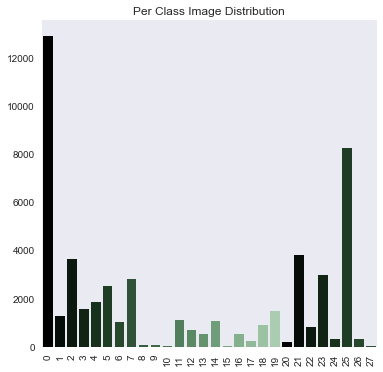

In [17]:
'''Per Class Image Distribution'''
a=np.array([mlb.transform([np.array(i)]).squeeze() for i in dataset.df.Targets])

classes = np.arange(0,28)
counts = [sum(cls) for cls in a.T]
one_label = [index for index,row in enumerate(a) if sum(row)==1]
print(len(one_label))
for i,j in zip(classes,counts):print('Class {:d}: {:d}'.format(i,j),end='\t')

plt.figure(figsize=(6,6))
pal = sns.cubehelix_palette(n, start=2, rot=0, dark=0, light=.75, reverse=True)
g = sns.barplot(y=counts, x=classes, palette=pal)
g.set_title("Per Class Image Distribution")
g.set_xticklabels(g.get_xticklabels(),rotation=90);

In [18]:
losses = {}
accuracys = {}

losses['train'] = []
losses['val'] = []
accuracys['train'] = []
accuracys['val'] = []

In [20]:
import sys
def Train(model, epochs, criterion, scheduler, acc = 'normal', path = './model.pth', optimizer= None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = sys.maxsize+0.0


    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.04, betas=(0.9, 0.99))

    print("training with device: " + str(torch.cuda.current_device()))
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0    
            running_corrects = 0.0
    
            for i, data in enumerate(dataloaders[phase], 0):            
                # get the inputs
                inputs, labels = data['image'], data['target']

                inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                print('Batch {:d}/{:d}'.format(i,int(dataset_sizes[phase]/BATCH_SIZE)), end='\r', flush=True)
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):    
                    outputs = model(inputs)
                    preds = outputs > 0 # similar to F.sigmoid(outputs) > 0.5
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                labels = labels.data.byte()
                if acc == 'normal':
                    running_corrects += torch.sum((labels == preds))
                else:
                     running_corrects += torch.sum((labels == preds).all(1)) # All 28 instances need to be correctly labelled
                     
            epoch_loss = running_loss / dataset_sizes[phase]
            if acc == 'normal':
                epoch_acc = running_corrects.float() / (len(LABELS)*dataset_sizes[phase])
            else:
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            with open('report_attempt1.txt','a') as report:
                report.write('Epoch: {:d} {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))
                report.write('\n')
                
            losses[phase].append(epoch_loss)
            accuracys[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
                
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model

In [22]:
# training
PATH = './model.pth'
torch.cuda.empty_cache()
cnn = Train(resnet34, 30,  criterion, exp_lr_scheduler, path = PATH, optimizer=optimizer_ft)

training with device: 0
Epoch 1/30
----------
train Loss: 1.7047 Acc: 0.9325
val Loss: 1.4627 Acc: 0.9402
Epoch 2/30
----------
train Loss: 1.4300 Acc: 0.9400
val Loss: 1.4327 Acc: 0.9387
Epoch 3/30
----------
train Loss: 1.4022 Acc: 0.9402
val Loss: 1.4280 Acc: 0.9409
Epoch 4/30
----------
train Loss: 1.3876 Acc: 0.9406
val Loss: 1.4294 Acc: 0.9400
Epoch 5/30
----------
train Loss: 1.3799 Acc: 0.9405
val Loss: 1.4691 Acc: 0.9395
Epoch 6/30
----------
train Loss: 1.3286 Acc: 0.9413
val Loss: 1.3854 Acc: 0.9400
Epoch 7/30
----------
train Loss: 1.3210 Acc: 0.9415
val Loss: 1.3827 Acc: 0.9407
Epoch 8/30
----------
train Loss: 1.3194 Acc: 0.9416
val Loss: 1.3808 Acc: 0.9405
Epoch 9/30
----------
train Loss: 1.3182 Acc: 0.9416
val Loss: 1.3809 Acc: 0.9403
Epoch 10/30
----------
train Loss: 1.3179 Acc: 0.9414
val Loss: 1.3842 Acc: 0.9409
Epoch 11/30
----------
train Loss: 1.3117 Acc: 0.9417
val Loss: 1.3768 Acc: 0.9409
Epoch 12/30
----------
train Loss: 1.3101 Acc: 0.9416
val Loss: 1.3767 A

In [20]:
!gpustat

k80server  Sat Dec  1 01:08:51 2018
[0] Tesla K80        | 41'C,   0 % | 10956 / 11441 MB | tahsin(10942M)
[1] Tesla K80        | 37'C,   0 % |  2899 / 11441 MB | avijit(2888M)
[2] Tesla K80        | 39'C,   0 % | 10960 / 11441 MB | aowal(10942M)
[3] Tesla K80        | 36'C,   0 % | 10937 / 11441 MB | aowal(10923M)


In [ ]:
# training full network

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(resnet34.parameters(), lr=0.01, betas=(0.9, 0.99))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

PATH = './model.pth'
set_parameter_requires_grad(cnn, True)
torch.cuda.empty_cache()
cnn = Train(cnn, 56,  criterion, exp_lr_scheduler, path = PATH, optimizer=optimizer_ft)

training with device: 0
Epoch 1/56
----------
train Loss: 1.3450 Acc: 0.9416
val Loss: 1.3617 Acc: 0.9413
Epoch 2/56
----------
train Loss: 1.3431 Acc: 0.9417
val Loss: 1.3385 Acc: 0.9415
Epoch 3/56
----------
train Loss: 1.3426 Acc: 0.9417
val Loss: 1.3391 Acc: 0.9415
Epoch 4/56
----------
train Loss: 1.3420 Acc: 0.9417
val Loss: 1.3376 Acc: 0.9415
Epoch 5/56
----------
train Loss: 1.3417 Acc: 0.9417
val Loss: 1.3386 Acc: 0.9415
Epoch 6/56
----------


In [68]:
# torch.save(cnn.state_dict(), 'current_model.pth')

cnn = resnet34
cnn.load_state_dict(torch.load('model.pth'))

In [53]:
# !gpustat
# print(torch.cuda.is_available())
# print(torch.cuda.current_device(), torch.cuda.device_count())

# Visualize training curve

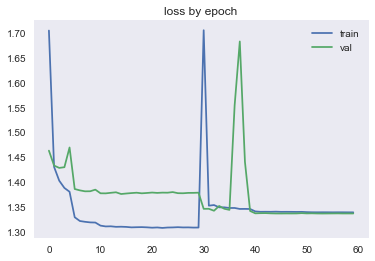

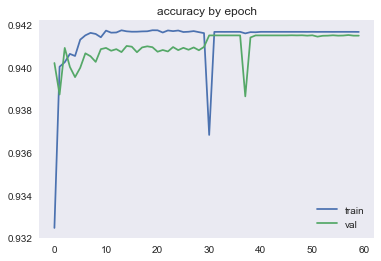

In [54]:
plt.plot(np.arange(len(losses['train'])), losses['train'],label="train")
plt.plot(np.arange(len(losses['val'])), losses['val'], label="val")
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(accuracys['train'])), accuracys['train'], label="train")
plt.plot(np.arange(len(accuracys['val'])), accuracys['val'], label="val")
plt.title("accuracy by epoch")
plt.legend()
plt.show()

# Validation & Find Thresholds

In [69]:
from tqdm import tqdm

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def test_model(model,batch):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = batch
    inputs = inputs.to(device,dtype=torch.float)
    out = model(inputs)
    out = out.cpu()
    return out

valPreds = np.empty((0, 28))
valLabels = np.empty((0, 28))
for sample_batched in tqdm(dataloaders['val']):
    out = test_model(cnn,sample_batched['image'])
    out = out.detach().numpy()
    preds = sigmoid_np(out)
    labels = sample_batched['target']
    valPreds = np.append(valPreds,preds,axis=0)
    valLabels = np.append(valLabels,labels,axis=0)
    
print(valPreds.shape,valLabels.shape)    

100%|██████████| 25/25 [00:38<00:00,  1.56s/it]

(6214, 28) (6214, 28)


100%|██████████| 1000/1000 [00:46<00:00, 21.68it/s]


Individual F1-scores for each class:
[5.86602980e-01 7.87143326e-02 2.09292228e-01 9.33312798e-02
 1.11162719e-01 1.41595570e-01 6.08222902e-02 1.63168785e-01
 1.76678445e-03 3.33945567e-03 2.06753963e-03 6.70513020e-02
 4.90050978e-02 3.71148459e-02 6.61672909e-02 7.08842814e-04
 3.33388898e-02 1.40080546e-02 6.27438739e-02 8.63492063e-02
 9.79431929e-03 2.30850902e-01 5.06890543e-02 1.82286928e-01
 1.85697996e-02 4.24096386e-01 2.17245989e-02 3.50692618e-04]
Macro F1-score CV = 0.10023978740628718
Probability threshold maximizing CV F1-score for each class:
[0.    0.237 0.304 0.243 0.261 0.285 0.221 0.    0.091 0.081 0.07  0.214
 0.194 0.183 0.214 0.068 0.184 0.136 0.211 0.243 0.123 0.324 0.207 0.297
 0.154 0.391 0.154 0.055]


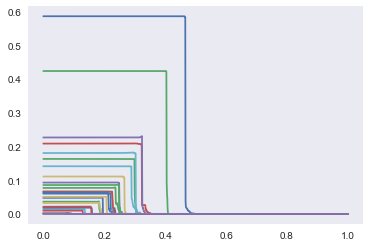

In [70]:
from sklearn.metrics import f1_score as sk_f1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(valPreds[:,i]>t, dtype=np.int8)
        scoref1 = sk_f1(valLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1
        
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))

plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

# th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
#                0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
#                0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

# submit


In [71]:
submit = pd.read_csv('./data/sample_submission.csv')

dataset_test = HumanProteinDataset(csv_file='./data/sample_submission.csv', transform=imgPreprocess(mean,std,30), test=True)

dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

'''https://www.kaggle.com/rejpalcz/cnn-128x128x4-keras-from-scratch-lb-0-328'''
'''https://www.kaggle.com/avipartho/pretrained-resnet34-with-rgby-0-460-public-lb'''
'''https://pytorch.org/docs/stable/optim.html''' # differential lr
'''https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html''' # finetuning model
'''https://github.com/spytensor/kaggle_human_protein_baseline''' # .461 baseline

'https://github.com/spytensor/kaggle_human_protein_baseline'

In [72]:
ids = []
predictions = []

for sample_batched in tqdm(dataloader_test):
    out = test_model(cnn,sample_batched['image'])
    preds = []
    out = out.detach().numpy()
    out = sigmoid_np(out)
    for sample in out:
        p = ""
        for i,label in enumerate(sample):
            if label > T[i]:
                p += " " + str(i)
        if p == "":
            p = "0"
        else:
            p = p[1:]
        preds.append(p)

    ids += list(sample_batched['Id'])
    predictions += preds    


100%|██████████| 46/46 [01:07<00:00,  1.47s/it]


In [73]:
print(predictions[:10])

['0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27', '0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27']


In [74]:
df = pd.DataFrame({'Id':ids,'Predicted':predictions})
df.to_csv('protein_classification.csv', header=True, index=False)

df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 1 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 1...
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
